# Ever Wonder Whether Weather Sways Stocks?

By [Jeff Price](https://www.linkedin.com/in/jpjeffprice). 

This modeling project analyzed data from several sources to explore whether the atmospheric conditions outside the New York Stock Exchange (NYSE) have any affect on trading inside the building. To wit, does a gloomy day outside make traders more pessimistic, does a tough trek through the snow sap their patience when trading, or do high temperatures and clear skies provide a boost in temperament that translates into high stock valuations?

## Data Sources

To populate the model, I downloaded stock market data for the S&P 500 from [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1479445200&period2=1510981200&interval=1d&filter=history&frequency=1d), which included the opening, closing, and highest and lowest trade for each trading day over the year 18 November 2016 to 18 November 2017. Thought this clearly doesn’t represent every stock traded on the NYSE, for the purposes of my model it is serving as a proxy for overall NYSE trading. I then collected weather data from wunderground.com for the Central Park, NY weather station, [KNYC](https://www.wunderground.com/history/airport/KNYC/2016/11/18/CustomHistory.html?dayend=18&monthend=11&yearend=2017&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=). This data set spanned all days between 18 November 2016 and 18 November 2017, and included the average wind speed, temperature (in Fahrenheit), humidity, visibility (in miles), dew point, and sea level pressure, as well as the high and low readings. It also included precipitation in inches and a category for they type of precipitation (i.e. rain, snow, or fog), which could include multiple precipitation types on a given day.

## Data Wrangling
These data sets didn't match initially, since the market data only included entries for days the NYSE was open, while the weather data included readings for every single day. To correct this, I just deleted the weather data entries for the weekends and NYSE holidays.

Further, some of the entries in the weather precipitation column included the non-numerical value 'T'. This indicated trace precipitation, which is too little to measure but still significant enough to note. For practical purposes I treated this as zero precipitation, and replaced all the T's with '0'.

I then added a few columns for the row ID, date, and the daily change in the S&P 500, which I calculated by subtracting the closing value from the opening value. This sometimes resulted in a negative number. In addition, I deleted most of the other columns, only leaving the aforementioned daily stock market change, the average temperature, average visibility, average wind, and amount of precipitation. I didn't try to account for the type of precipitation, reasoning that the regression analysis would partially capture this via the combination of temperature and precipitation level during regression (e.g. if there's precipitation and the temperature is high, it was probably raining).

## The Model
The model itself was a linear regression where SPchange = NYCtemp + Visibility + NYCwind + NYCprecip. The variables used are defined as follows:

SPchange = daily change in the value of the S&P 500 stock index, calculated by subtracting the closing price from the opening price

NYCtemp = average temperature, as measured at weather station KNYC (data provided; not calculated)

Visibility = average visibility in miles, as measured at the KNYC weather station (data provided; not calculated)

NYCwind = average wind, as measured at weather station KNYC (data provided; not calculated)

NYCprecip = precipitation in inches (including rain, snow, etc), as measured at weather station KNYC (data provided; not calculated)

## Training, Cross Validation, and Results
Visualizing some of the data (both NYCprecip graphed against SPchange and NYCtemp graphed against SPchange), there didn’t appear to be much of correlation. The data was all over the graph, and the best fit line didn’t seem to have much predictive power. However, I was curious whether all the variables taken together might better predict changes in the SPchange variable.

I initially utilized the 5% test sample size, utilizing 95% of my data to train the model. However, I initially got a negative accuracy from the validation module. This caused me to explore holding back more of the data to test against, shrinking my training data. The results of that are as follows:

10% test data resulted in a R2 of 0.023 and accuracy of -0.00422219571875

15% test data resulted in a R2 of 0.034 and accuracy of -0.0861092821173

20% test data resulted in a R2 of 0.032 and accuracy of -0.0117661970201

The smaller test data samples appeared to have increasing accuracy scores (i.e. they were less negative). Curiously, when I tried the 5% test sample size again, I got a R2 of 0.022 and positive accuracy scores of 0.0453505452191 and 0.0190130984933 for each of two trials. This indicates to me that the model is very weak, only getting positive accuracy scores at small test sample sizes, and even then not all the time. Further, as the R2 indicates, these variables are only explaining 2-3% of the dependant variable SPchange.

I interpret these results to mean that my model is not very good at explaining price changes for the S&P 500 stock index.

## Ideas for Improvement
In light of distributed online trading and computer automation, it is perhaps not surprising that the weather outside the NYSE would have so little effect on trading within the building. Any effect is probably diluted by trades being called in from afar or automated machines that don’t even know the weather.

To improve the model, I could use multiple weather station inputs rather than just one, I could go back many years to see if more date would increase the predictive power of the model (not likely at such an already low R2), or I might try to proxy NYSE trading with other variables, such as trade volume (instead price change). All these tweaks might make the model more robust, but it likely won’t increase its explanatory power too much. To really test for a link between weather and stock trading at the NYSE, I would probably have to round up much older historical data from before the proliferation of online/electronic trading. In the future, it would be interesting to see if 100 years ago the weather really did have an impact on what happened on the stock-trading floor.


In [53]:
import os
try:
    inputFunc = raw_input
except NameError:
    inputFunc = input

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
 
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import random



# Custom functions

def evaluate(pred, labels_test):
    acc = accuracy_score(pred, labels_test)
    print ("Accuracey: %s"%acc)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall = tp / (tp + fp)
    percision = tp / (tp + fn)
    f1 = (2 / ((1/recall)+(1/percision)))

    print ("")
    print ("True Negatives: %s"%tn)
    print ("False Positives: %s"%fp)
    print ("False Negatives: %s"%fn)
    print ("True Positives: %s"%tp)
    print ("Recall: %s"%recall)
    print ("Precision: %s"%percision)
    print ("F1 Score: %s"%f1)

def plot_bound(Z_val,data,col1,col2,binary):
    # Z-val equals "Yes" value. E.g., "Y" or "1". 
    # data equals df
    # col1 and col2 defines which colums to use from data
    # Plot binary decision boundary. 
    # For this, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    
    x_min = float(data.iloc[:,[col1]].min())-float(data.iloc[:,[col1]].min())*0.10 
    x_max = float(data.iloc[:,[col1]].max()+float(data.iloc[:,[col1]].min())*0.10)
    y_min = 0.0; 
    y_max = float(training.iloc[:,[col2]].max())+float(training.iloc[:,[col2]].max())*0.10
    h_x = (x_max-x_min)/100  # step size in the mesh
    h_y = (y_max-y_min)/100  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
    if binary == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   
        Z = np.where(Z=="Y",1,0)
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.pcolormesh(xx, yy, Z)
    plt.show()

## Data Cleaning

Here we load the data we collected and get it all ready to feed to our statistical model(s). That is, we are trying to make a table with one **target** column and one or more **features**. Here I'm loading happiness.csv from: https://data.somervillema.gov/Happiness/Somerville-Happiness-Survey-responses-2011-2013-20/w898-3dfm Note: you can find information on the data elements at this link. 


In [54]:
# Load and peek at your data. Change the file name as needed. 
raw_data_df = pd.read_csv('cleandata2.csv', parse_dates=[0]) 
raw_data_df.head()

,ID,Date,SPchange,NYCtemp,Visibility,NYCwind,NYCprecip
0,1,11/18/16,-4.95,54,10,8,0.00
1,2,11/21/16,11.75,39,10,22,0.00
2,3,11/22/16,1.38,39,10,21,0.00
3,4,11/23/16,6.17,40,10,12,0.00
4,5,11/25/16,7.08,50,7,9,0.02


In [55]:
# You can explore unique entires by stating the column and using .unique() like this:
print(raw_data_df["NYCtemp"].unique())
print(raw_data_df["NYCwind"].unique())

[54 39 40 50 45 56 48 46 44 42 43 35 38 27 22 37 41 30 29 19 34 47 57 32 26
 55 64 53 62 36 49 23 51 33 71 67 66 58 52 72 69 61 68 78 84 79 63 65 59 85
 86 77 70 76 80 75 81 74 83 82 73 60]
[ 8 22 21 12  9 10 13 18 20 17 15  6 14 25 16 33 24 23 28 26  7]


In [56]:
# I'm now going to make a set of tables to be used in training some models
# The first set will be for linear regressions where the traget is numeric.
# Happiness
stock_wx_df = raw_data_df[[
                               'SPchange', 
                               'NYCtemp', 
                               'Visibility',
                                'NYCwind',
                                'NYCprecip'
                               ]].copy()
stock_wx_df.head()

,SPchange,NYCtemp,Visibility,NYCwind,NYCprecip
0,-4.95,54,10,8,0.00
1,11.75,39,10,22,0.00
2,1.38,39,10,21,0.00
3,6.17,40,10,12,0.00
4,7.08,50,7,9,0.02


## Taining and Validation

Above I created four datasets worth exploring: 
- **`happy_lin_df`**. The data needed to access *happiness* along a continuous variable.
- **`sat_lin_df`**. The data needed to access *satisfaction* along a continuous variable.
- **`happy_class_df`**. The data needed to access *happiness* as a categorical variable.
- **`sat_class_df`**. The data needed to access *satisfaction* as a categorical variable.

Let's take them each in turn. 

## stock_wx_df



In [57]:
data = stock_wx_df

holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

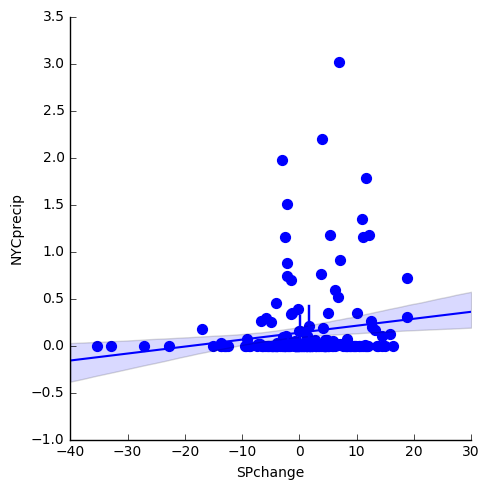

In [28]:
sns.lmplot(x="SPchange", y="NYCprecip", data=training, x_estimator=np.mean, order=1)

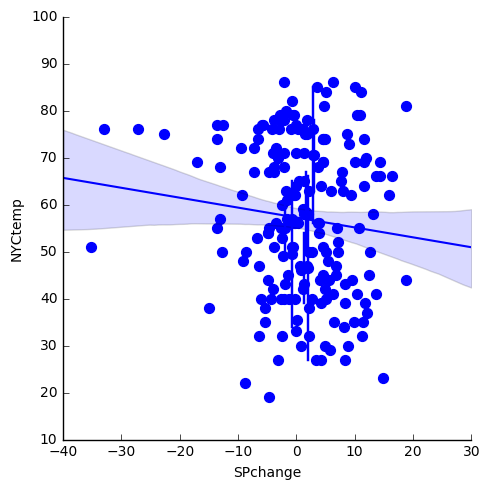

In [29]:
sns.lmplot(x="SPchange", y="NYCtemp", data=training, x_estimator=np.mean, order=1)

In [58]:
model = ols("SPchange ~ NYCtemp + Visibility + NYCwind + NYCprecip", training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               SPchange   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.387
Date:                Mon, 04 Dec 2017   Prob (F-statistic):              0.239
Time:                        18:09:51   Log-Likelihood:                -839.87
No. Observations:                 239   AIC:                             1690.
Df Residuals:                     234   BIC:                             1707.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5790      4.712      0.123      0.902        -8.703     9.861
NYCtemp       -0.0213      0.036     -0.589      0.556        -0.092     0.050
Visibility    -0.0532      0.361     -0.147      0.883        -0.765     0.659
NYCwind        0.1283      0.151      0.852      0.395        -0.168     0.425
NYCprecip      2.0565      1.946      1.057      0.292        -1.778     5.891
==============================================================================
Omnibus:                       42.313   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.568
Skew:                          -0.767   Prob(JB):                     8.03e-26
Kurtosis:                       6.042   Cond. No.                         556.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
# Rerun with SciKitLearn because it's easy to check accuracy
features_train = training.drop("SPchange", axis=1).as_matrix(columns=None)
labels_train = training["SPchange"].as_matrix(columns=None)

features_test = holdout.drop("SPchange", axis=1).as_matrix(columns=None)
labels_test = holdout["SPchange"].as_matrix(columns=None)

lm = linear_model.LinearRegression()
clf = lm.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = metrics.r2_score(labels_test, pred)
print("R squared:",lm.score(features_train,labels_train))
print("Accuracy:",accuracy)

R squared: 0.0231549699348
Accuracy: 0.0190130984933
